## Clean the jyper notebook number 8

1. This is a copy of the TrialMatrix_leverPress_Pascal_8.ipynb

To create the trial Matrix instead of select the based on interval atLever, just select 2 secs before or after the leverPress independent of the location of the animal

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run ../setup_project.py
%run ../neuronAutopi.py

%run ../generic_plot_functions.py
import os.path
from spikeA.Dat_file_reader import Dat_file_reader
from scipy.signal import welch
from scipy.ndimage import gaussian_filter1d
import numpy as np
from scipy.signal import find_peaks, peak_widths, peak_prominences
from scipy import integrate
from scipy.ndimage import gaussian_filter1d 
import os
from itertools import product
from scipy.stats import pearsonr
from scipy import signal

projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_inter",
                                                                dataPath="/adata/projects/autopi_inter/",dlcModelPath="/adata/models")


creating myProject, an autopipy.project object
Project name: autopi_inter
dataPath: /adata/projects/autopi_inter/
dlcModelPath: /adata/models
Reading /adata/projects/autopi_inter//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [2]:
prepareSessionsForSpatialAnalysisProject(sSessions[:],myProject.sessionList[:]) ### sSeslist >>>> sSessions

Loading Animal_pose and Spike_train, sSes.ap and sSes.cg
Will load .pose.npy


100%|█████████████████████████████████████████| 180/180 [04:45<00:00,  1.59s/it]


Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [3]:
for ses, sSes in tqdm(zip(myProject.sessionList[:],sSessions[:])):
    getSearchHomingIntervals(ses,sSes)

180it [00:06, 28.78it/s]


In [4]:
def get_sSesId_nId(cellId):
    
    sesName= cellId.split('_')[0]
    cellName= cellId.split('_')[1]
    sesid= [sSes.name for sSes in sSessions].index(sesName)
    sSes= sSessions[sesid]
    ses= myProject.sessionList[sesid]
    nid= [n.name for n in sSes.cg.neuron_list].index(cellName)
    n= sSes.cg.neuron_list[nid]
    return sSes,ses,n, nid 


## Get the leverPress time and plot the time of spikes in regard to the leverPress on the path 

In [5]:
%%time
fn=myProject.dataPath+"/results/cells_with_leverCells.csv"
print('loading', fn)
cells = pd.read_csv(fn)

## load the levertime press 
fn ='behavior_180_v2.csv'
print('loading', fn)
res = pd.read_csv(fn)

LeverPressinRestime= res[res.sessionName== sSes.name].levertimeRes.values
LeverPressinRestime.shape, len(ses.trials)


loading /adata/projects/autopi_inter//results/cells_with_leverCells.csv
loading behavior_180_v2.csv
CPU times: user 101 ms, sys: 8.16 ms, total: 110 ms
Wall time: 127 ms


((114,), 115)

In [6]:
#levercLid= list(cells[(cells.leverCell_all_light) & (cells.usable_auto_RF) & (cells.leverCell_all_dark== False)].cluId)
#levercDid= list(cells[(cells.leverCell_all_dark) & (cells.usable_auto_RF) & (cells.leverCell_all_light== False) ].cluId)


## create the IFRstacked around leverPress for all the cells in one session 

In [7]:
def samples2time(l):
    return bin_size_sec*(np.arange(l)-l/2+.5)

In [8]:
def get_stacked_ifr_all_cropped(sSes,ses):
    session_trials = res[(res.sessionName == sSes.name) & (res.valid==True)].sort_values(by='trialNo')
    LeverPressinRestime = session_trials.levertimeRes.values
    
    atLever_times = np.concatenate([ses.intervalDict['atLever_light'], ses.intervalDict['atLever_dark']])
    
    
    
    trial_lever_times = []
    # loop through trials in the same order as trial dataframe "session_trials"
    for i,LeverPress in enumerate(LeverPressinRestime):
        # find atLever time interval for given trial
        found = False
        for (start,end) in atLever_times:
            if start <= LeverPress <= end:
                found = True
                break
        if not found:
            # raise IOError("not found")
            continue
        if found:
            #print("trial",i,"LeverPress",LeverPress,"occurs within",start,end) # keep the index of trial so we can reference in case one is not found
            trial_lever_times.append({'trial_id': i, 'start': start, 'end': end, 'LeverPress': LeverPress})
            
            
            
    atLeverIFR_trials = [] # number of trials * number of cells * time

    for t in trial_lever_times:
        start,end = t['start'],t['end']

        # IFR around lever for each trial
        atLeverifr = [] # number of cells * time

        for n in sSes.cg.neuron_list:
            n.spike_train.set_intervals(np.array([start,end]))
            n.spike_train.instantaneous_firing_rate(bin_size_sec=bin_size_sec, sigma=sigma, time_start=start, time_end=end, outside_interval_solution="remove")
            n.spike_train.ifr[0][n.spike_train.ifr[0] > 80] = 0
            atLeverifr.append(n.spike_train.ifr[0])
        atLeverifr = np.array(atLeverifr) # number of cells * trial duration
        atLeverIFR_trials.append(atLeverifr)
        
        
    # get time before and after leverpress for aligned stack
    dt=[]
    for t in trial_lever_times:
        start,end,leverpress = t['start'],t['end'],t['LeverPress']
        dt.append(max(leverpress-start, end-leverpress))
    maxtime = np.max(dt)
    
    time_samples = int(np.ceil(maxtime/bin_size_sec)) # before and after lever press


    # stack : trials * time * cells
    # time aligning is by trial

    ncells = len(sSes.cg.neuron_list)
    ntrials = len(trial_lever_times)
    stackedifr_cells = np.zeros((ntrials, ncells, time_samples*2))
    stackedifr_cells[:] = np.nan # pad empty space with nan

    for i, (atLeverifr, t) in enumerate(zip(atLeverIFR_trials, trial_lever_times)):
        # print('trial',i,t,'/',"IFR shape:",atLeverifr.shape)
        # align trials
        start,end,leverpress = t['start'],t['end'],t['LeverPress']
        left_pad_samples = time_samples - int(np.ceil((leverpress-start)/bin_size_sec)) # how many nans to add before start (for this trial, all cells), so that lever press is centered
        stackedifr_cells[i,:,left_pad_samples:left_pad_samples+atLeverifr.shape[1]] = atLeverifr

    trial_ids = np.array([t['trial_id'] for t in trial_lever_times])
    # mask for light or dark
    trial_light = (session_trials.light == 'light').values
    trial_light_onids = trial_light[trial_ids]

    trials_light_ids = np.where(trial_light_onids)[0]
    trials_dark_ids = np.where(~trial_light_onids)[0]
    
    ###############
    #### Crop the stack 0.5 second before and after the leverPress to remove Nans 
    ##############
    time = samples2time(time_samples*2)

    # crop
    samples_to_keep = 50 #100
    indx0,indx1 = len(time)//2-samples_to_keep//2, len(time)//2+samples_to_keep//2
    time_scaled = time[indx0:indx1]
    stackedifr_cells = stackedifr_cells[:,:,indx0:indx1]
    #time, stackedifr_cells.shape

    #return stackedifr_cells, trials_light_ids, trials_dark_ids, time, time_scaled 
    return stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled 

In [9]:
def clean_stack(stack):
        return stack[~np.isnan(stack).any(axis=1)]
    
def plot_stackedifr_oneCell(gs, stackedifr_cells, cindx, trials_light_ids, trials_dark_ids, legend=True, bbox_to_anchor=(1.35, 1), nonan=True):
        
    # For light trials
    ax = fig.add_subplot(gs[0])
    stackedifr_light = stackedifr_cells[trials_light_ids, cindx, :]
    if nonan:
        stackedifr_light = clean_stack(stackedifr_light)
        cat = ax.pcolor(stackedifr_light)
        ax.set_title(f"nid:{cindx} -{'light'}\n{'remove Nans'}", fontsize=9)
    else: 
        cat = ax.pcolor(stackedifr_light)
        ax.set_title(f"nid:{cindx} -{'light'}", fontsize=9)
    
    # Modify the x-axis
    xticks_positions = [0, stackedifr_light.shape[1] // 2, stackedifr_light.shape[1] - 1]
    ax.set_xticks(xticks_positions)
    ax.set_xticklabels([-0.5, 0, 0.5])
    ax.set_xlabel("time relative \n to lever press [s]")
    ax.set_ylabel("Trials")

    # Add red vertical dashed line at 0
    ax.axvline(xticks_positions[1], color='red', linestyle='--', label="at lever press")
    fig.colorbar(cat, ax=ax)

    # For dark trials
    ax = fig.add_subplot(gs[1])
    stackedifr_dark = stackedifr_cells[trials_dark_ids, cindx, :]
    if nonan:
        stackedifr_dark = clean_stack(stackedifr_dark)
        cat = ax.pcolor(stackedifr_dark)
        ax.set_title(f"nid:{cindx} -{'dark'}\n{'remove Nans'}", fontsize=9)
    else: 
        cat = ax.pcolor(stackedifr_dark)
        ax.set_title(f"nid:{cindx} -{'dark'}", fontsize=9)
    
    xticks_positions = [0, stackedifr_dark.shape[1] // 2, stackedifr_dark.shape[1] - 1]
    ax.set_xticks(xticks_positions)
    ax.set_xticklabels([-0.5, 0, 0.5])
    ax.set_xlabel("time relative \n to lever press [s]")
    ax.set_ylabel("Trials")

    # Add red vertical dashed line at 0
    ax.axvline(xticks_positions[1], color='red', linestyle='--', label="leverPress")
    fig.colorbar(cat, ax=ax)
    
    if legend:
        ax.legend(loc='upper center', bbox_to_anchor=bbox_to_anchor)

Now get the expected values

In [10]:
def expected_value(v,w):
    indxs=np.isfinite(v)&np.isfinite(w)
    return np.average(v[indxs],weights=w[indxs])

def plot_expected_value(ax, stackedifr_cells,trials_light_ids,cindx, light= 'light', nonan= False):
    
    #ax= fig.add_subplot(gs[0])
    ifrstack= stackedifr_cells[trials_light_ids,cindx,:]

    if nonan:
        ifrstack=  ifrstack[~np.isnan(ifrstack).any(axis=1)]
    
    s0 = np.nanmean(ifrstack, axis=(0)) # axis: trials * 1 neuron
    t_mean = expected_value(time_scaled,s0) ## averaged expected_value 
    print(t_mean)
    l = ax.plot(time_scaled,s0,label='{} {}'.format(light, cindx))
    ax.axvline(t_mean, c='green', lw=1.5, label="leverPress")
    ax.axvline(0,linestyle='--', c='red', lw=1.0, label="leverPress")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("relative time to \n lever press [s]")
    ax.set_ylabel("sum of firing rate [Hz] \n  of all trials")
    ax.set_title(f"{light} \n exp_val:{t_mean:.3f} " , fontsize= 9)

def plot_expValues_oneCell(gs, stackedifr_cells, trials_light_ids, trials_dark_ids,  nonan= False):

    for i, (l,light_inx) in enumerate(zip(['light', 'dark'], [trials_light_ids, trials_dark_ids])):
        ax= fig.add_subplot(gs[i])
        plot_expected_value(ax, stackedifr_cells,light_inx,cindx, light= l,  nonan= nonan)

In [11]:
bin_size_sec = 0.02
sigma=1

ses= myProject.sessionList[15]
sSes= sSessions[15]

In [12]:
stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled = get_stacked_ifr_all_cropped(sSes,ses)

We have some trials that although they are labeled as valid trials but the leverPress is Nan .. we see a difference between length of trials 

stackedifr_cells: FinalValidTrials* numCells* 50 samples 

In [13]:
stackedifr_cells.shape, len(sSes.cg.neuron_list), np.concatenate([ses.intervalDict['atLever_light'], ses.intervalDict['atLever_dark']]).shape 

((113, 46, 50), 46, (120, 2))

0.019180505404830524
0.022968904402051977
0.017567062894583964
0.03629496470162144


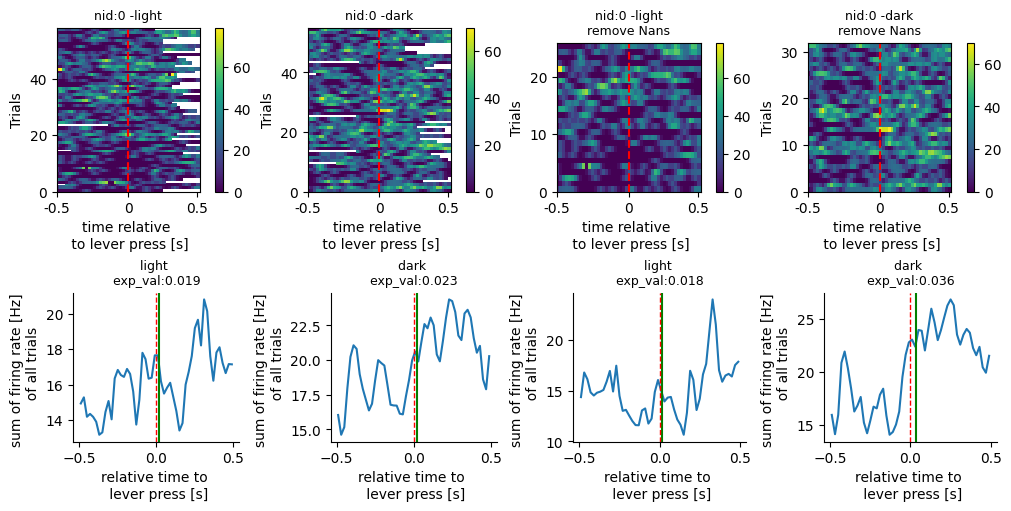

In [14]:
col=4
row=2
sizePerRow, sizePerCol = 2.5,2.5
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(row,col, figure=fig, wspace= 0.8) # all our figure

cindx= 0

gs0= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0,:2])#, width_ratios=[1.5,2,1,1])
plot_stackedifr_oneCell(gs0, stackedifr_cells,cindx,trials_light_ids,trials_dark_ids, legend= False, bbox_to_anchor= (1.45,1), nonan=False)

gs1= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1,:2])#, width_ratios=[1.5,2,1,1])
plot_expValues_oneCell(gs1, stackedifr_cells, trials_light_ids, trials_dark_ids, nonan= False)


gs2= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0,2:])#, width_ratios=[1.5,2,1,1])
plot_stackedifr_oneCell(gs2, stackedifr_cells,cindx,trials_light_ids,trials_dark_ids, legend= False, bbox_to_anchor= (1.45,1), nonan=True)

gs3= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1,2:])#, width_ratios=[1.5,2,1,1])
plot_expValues_oneCell(gs3, stackedifr_cells, trials_light_ids, trials_dark_ids, nonan= True)

### Get multiple cells for example all fs and grid cells together 

In [15]:
ses= myProject.sessionList[10]
sSes= sSessions[10]

In [16]:
stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled = get_stacked_ifr_all_cropped(sSes,ses)

In [17]:
def plot_cellTypes_expValues(ax, sSes, trials_light_ids, trials_dark_ids, stackedifr_cells, bbox_to_anchor=(1.5, 1.0), legend=True, nonan=False):
    
    session_cells = cells[(cells.session == sSes.name)]
    gc_indx = session_cells.gridCell_FIRST.values
    fsin_indx = ((session_cells.interneuron) & (session_cells.mrate_RF1 > 10)).values

    cell_filters = [fsin_indx, gc_indx]
    cell_filters_str = ['FSIN', 'GC']

    light_conditions = [trials_light_ids, trials_dark_ids]
    light_conditions_str = ['light', 'dark']

    neuron_fr_max = np.nanmax(stackedifr_cells, axis=(0, 2))

    # Normalize the data
    stackedifr_cells_normalized = (stackedifr_cells.transpose((0, 2, 1)) / neuron_fr_max).transpose(0, 2, 1)

    expvals = []
    for light_condition, light_condition_str in zip(light_conditions, light_conditions_str):
        for cell_filter, cell_filter_str in zip(cell_filters, cell_filters_str):
            ifrstack = stackedifr_cells_normalized[light_condition][:, cell_filter]
            if nonan: 
                ifrstack= ifrstack[~np.isnan(ifrstack).any(axis=(1,2))]
            #print(ifrstack.shape)
            s0 = np.nanmean(ifrstack, axis=(0, 1))  # Mean across trials and neurons
            t_mean = expected_value(time_scaled, s0)  # Calculate expected value
            expvals.append(t_mean)
            l = ax.plot(time_scaled, s0, label='{} {}'.format(light_condition_str, cell_filter_str))
            ax.axvline(t_mean, c=l[0].get_color(), lw=1, alpha=0.6)

    if legend:
        ax.legend(loc='upper center', bbox_to_anchor=bbox_to_anchor)

    exvalsDiff = expvals[0] - expvals[1]
    ax.set_title(f"Mean by cell types\nFSExpVal-gcExpVal:{exvalsDiff:.3f}", fontsize=9)
    if nonan: 
        ax.set_title(f"Mean by cells & trials\n FSExpVal-gcExpVal:{exvalsDiff:.3f}\n {'Remove Nans'}", fontsize=9)
    else: 
        ax.set_title(f"Mean by cells & trials\n FSExpVal-gcExpVal:{exvalsDiff:.3f}\n fs:{sum(fsin_indx)}, gc:{sum(gc_indx)}", fontsize=9)
        
    ax.set_xlabel("time relative to \n lever press [s]", fontsize=9)
    ax.set_ylabel("mean firing rate [Hz]", fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


In [18]:
def plot_compare_allCells_expVal(gs, sSes, stackedifr_cells, trials_light_ids, light= 'light'):
    
    session_cells = cells[(cells.session == sSes.name)]
    gc_indx = session_cells.gridCell_FIRST.values
    fsin_indx = ((session_cells.interneuron) & (session_cells.mrate_RF1 > 10)).values
    
    stacked_ifr_fs= stackedifr_cells[trials_light_ids][:,fsin_indx] # use raw
    stacked_ifr_gc= stackedifr_cells[trials_light_ids][:,gc_indx] # use raw

    stacked_ifrs = [stacked_ifr_fs, stacked_ifr_gc] 
    cell_types = ['FS', 'gc']
    light_conditions = [light, light] 
    # Loop through the light conditions and cell types
    for i, (light, ctype, stacked_ifr) in enumerate(zip(light_conditions, cell_types, stacked_ifrs)):
        ax = fig.add_subplot(gs[i])
        if ctype== 'FS':
            ax.plot(time_scaled, np.nanmean(stacked_ifr, axis=0).T, alpha= 0.6)
        else: 
            ax.plot(time_scaled, np.nanmean(stacked_ifr, axis=0).T, alpha= 0.6)
        ax.set_xlabel("time relative to \n lever press [s]", fontsize=9)
        ax.set_ylabel("mean firing rate [Hz]", fontsize=9)
        ax.set_title(f'{ctype}_{light}', fontsize=9)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

In [19]:
def Compare_nans_withoutnan(gs):

    # Define the parameters for looping
    plot_configs = [
        {'subplot_index': 0, 'legend': False, 'nonan': False},
        {'subplot_index': 1, 'legend': True, 'nonan': True}
    ]

    # Loop through the configurations and plot
    for config in plot_configs:
        ax = fig.add_subplot(gs[config['subplot_index']])
        plot_cellTypes_expValues(ax, sSes,trials_light_ids, trials_dark_ids, stackedifr_cells, bbox_to_anchor=(1.5, 1.0), legend=config['legend'], nonan=config['nonan'] )

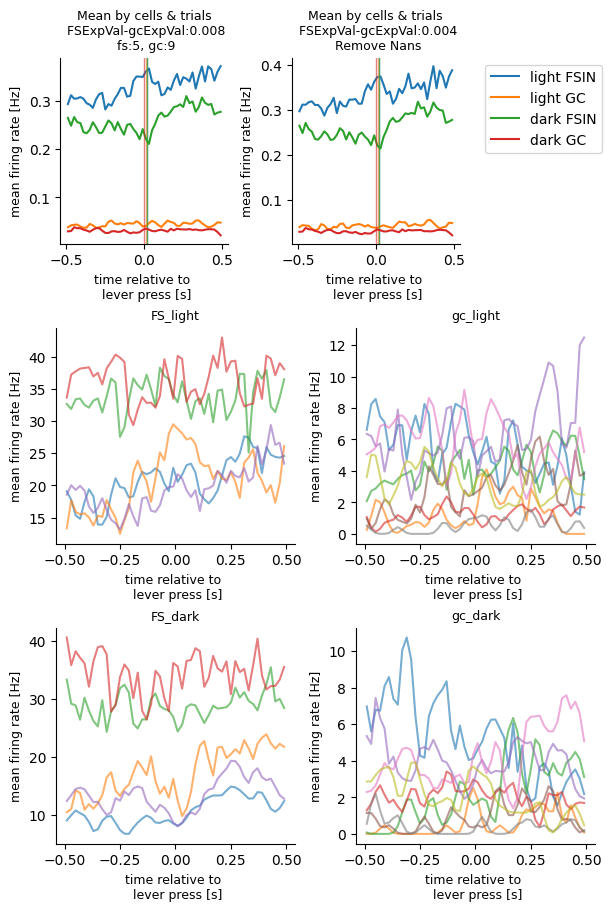

In [20]:
col=2
row=3
sizePerRow, sizePerCol = 3,3
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(row,col, figure=fig, wspace= 0.1) # all our figure

gs0= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0,:])#, width_ratios=[1.5,2,1,1])
Compare_nans_withoutnan(gs0)

gs1= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1,:])#, width_ratios=[1.5,2,1,1])
plot_compare_allCells_expVal(gs1, sSes, stackedifr_cells, trials_light_ids, light= 'light')

gs2= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[2,:])#, width_ratios=[1.5,2,1,1])
plot_compare_allCells_expVal(gs2, sSes, stackedifr_cells, trials_dark_ids, light= 'dark')

It seems that there is a sub-population of FS interneurons that has a peak and this peak changes per light condition

try with another session 

In [21]:
ses= myProject.sessionList[152]
sSes= sSessions[152]

stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled = get_stacked_ifr_all_cropped(sSes,ses)

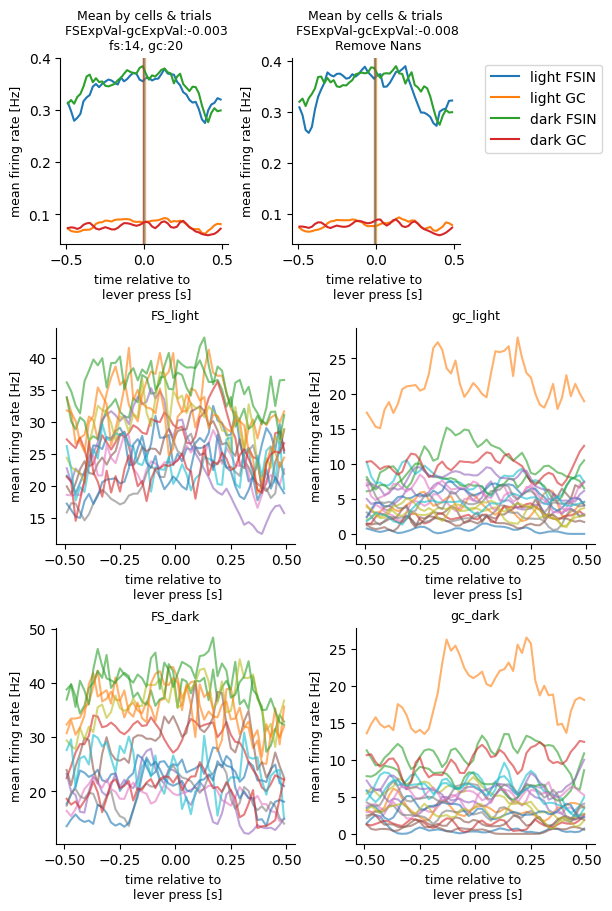

In [22]:
col=2
row=3
sizePerRow, sizePerCol = 3,3
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(row,col, figure=fig, wspace= 0.1) # all our figure

gs0= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0,:])#, width_ratios=[1.5,2,1,1])
Compare_nans_withoutnan(gs0)

gs1= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1,:])#, width_ratios=[1.5,2,1,1])
plot_compare_allCells_expVal(gs1, sSes, stackedifr_cells, trials_light_ids, light= 'light')

gs2= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[2,:])#, width_ratios=[1.5,2,1,1])
plot_compare_allCells_expVal(gs2, sSes, stackedifr_cells, trials_dark_ids, light= 'dark')

## Run the function for all sessions 

In [14]:
get_stacked_ifr_all_sessions = [get_stacked_ifr_all_cropped(sSes,ses) for sSes,ses in tqdm(zip(sSessions,myProject.sessionList))]

180it [04:11,  1.40s/it]


In [19]:
len(get_stacked_ifr_all_sessions), len(get_stacked_ifr_all_sessions[0])

(180, 4)

saving the list of lists: 

In [20]:
# Create a list of lists, each containing 4 np.arrays
list_of_lists = []
for i in range(len(get_stacked_ifr_all_sessions)):  # 180 iterations
    sublist = []
    for j in range(4):  # Each sublist contains 4 np.array objects
        sublist.append(get_stacked_ifr_all_sessions[i][j])
    list_of_lists.append(sublist)

# Save the list of lists using pickle
fn= 'stacked_ifr_all_sessions.pkl'
with open(fn, 'wb') as f:
    pickle.dump(list_of_lists, f)

print("Saved successfully!")


Saved successfully!


## Define a function that calculates the peak_to_baseline_diff for each cell:

In [56]:
def get_peak_to_baseline(stackedifr_cells, cind,time_scaled ):
    
    arr= np.nanmean(stackedifr_cells[:,cind,:], axis=0).T
    
    # Step 1: Find the index of the highest peak
    peak_index = np.argmax(arr)
    peak_value = arr[peak_index]

    # Step 2: Calculate the baseline mean
    # The baseline is calculated from the start up to (but not including) the peak
    baseline_mask = time_scaled < time_scaled[peak_index]
    baseline_values = arr[baseline_mask]
    baseline_mean = np.mean(baseline_values)

    # Step 3: Compare peak height to the baseline
    peak_to_baseline_diff = peak_value - baseline_mean
    
    return arr, peak_index, baseline_mean, peak_to_baseline_diff

def plot_peak_tobaseline_diff(ax, cind, arr, peak_index, baseline_mean, peak_to_baseline_diff ,  legend= True): #, text_pos= [-0.4, 32], legend= True):
    ax.plot(time_scaled, arr)
    ax.axvline(time_scaled[peak_index], color='r', linestyle='--', label=f'Peak')
    #ax.set_ylim(0,30)
    ax.set_ylabel('Firing rate Hz')
    ax.set_xlabel('Relative time \n to lever press [s]')
    ax.axhline(baseline_mean, color='g', linestyle='--', label=f'Baseline mean')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if legend:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_title(f'Peak_to_baseline:{peak_to_baseline_diff:.2f}\n peak at:{time_scaled[peak_index]:.2f}\n Baseline mean :{baseline_mean:.2f}', fontsize= 9)
    #plt.show()

Run on a single cell

In [51]:
ses= myProject.sessionList[10]
sSes= sSessions[10]

stack= get_stacked_ifr_all_sessions[10]

stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled = stack[0], stack[1], stack[2], stack[3]

In [52]:
#stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled = get_stacked_ifr_all_cropped(sSes,ses)

In [53]:

session_cells = cells[(cells.session == sSes.name)]
gc_indx = session_cells.gridCell_FIRST.values
fsin_indx = ((session_cells.interneuron) & (session_cells.mrate_RF1 > 10)).values

stacked_ifr_fs= stackedifr_cells[trials_light_ids][:,fsin_indx] # use raw
stacked_ifr_gc= stackedifr_cells[trials_light_ids][:,gc_indx] # use raw


In [127]:
stacked_ifr_fs.shape

(50, 5, 50)

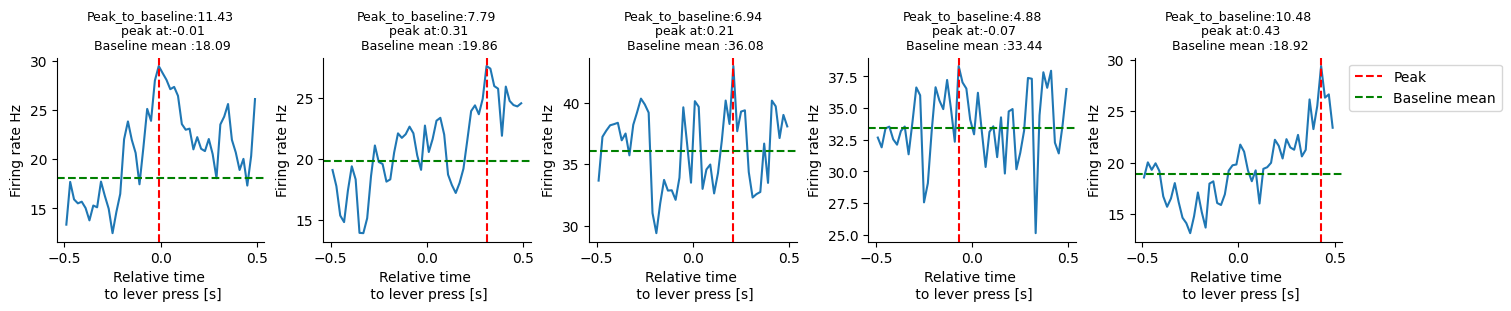

In [57]:
# Plot settings
col = 5
row = 1
sizePerRow, sizePerCol = 3, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

# Define the positions and text positions for each subplot
cinds = [1, 0, 3, 2, 4]  # Example cind values to loop through (0 to 4)
text_positions = [[-0.4, 32], [-0.4, 30], [-0.4, 45], [-0.4, 40], [-0.4, 31]]  # Example positions for text

for i, cind in enumerate(cinds):
    # Create subplot
    ax = fig.add_subplot(gs[i])
    
    # Get data for the current cind
    arr, peak_index, baseline_mean, peak_to_baseline_diff = get_peak_to_baseline(stacked_ifr_fs, cind, time_scaled)
    
    # Plot the data
    plot_peak_tobaseline_diff(ax, cind, arr, peak_index, baseline_mean, peak_to_baseline_diff, legend=(i == 4))  # Legend only for the third plot


## calculate mean baseline as the 5 sd of the mean_baseline 

In [79]:
arr = np.nanmean(stackedifr_cells[:, cind, :], axis=0).T

# Step 1: Find the index of the highest peak
peak_index = np.argmax(arr)
peak_value = arr[peak_index]

# Step 2: Calculate the baseline mean and standard deviation
# The baseline is calculated from the start up to (but not including) the peak
baseline_mask = time_scaled < time_scaled[peak_index]
baseline_values = arr[baseline_mask]

baseline_mean = np.mean(baseline_values)
baseline_std = np.std(baseline_values)

# Step 3: Define the threshold as 5 * std of the baseline
#threshold = baseline_mean + timestd * baseline_std
threshold = timestd * baseline_std

# Step 4: Calculate the difference between the peak and the threshold
peak_to_threshold_diff = peak_value - threshold

In [80]:
baseline_std, baseline_mean, peak_to_threshold_diff

(0.37996614035427384, 1.307076896890882, 0.06103072877442406)

In [129]:
def get_peak_to_baseline(stackedifr_cells, cind, time_scaled, timestd=5):
    
    arr = np.nanmean(stackedifr_cells[:, cind, :], axis=0).T
    
    # Step 1: Find the index of the highest peak
    peak_index = np.argmax(arr)
    peak_value = arr[peak_index]

    # Step 2: Calculate the baseline mean and standard deviation
    # The baseline is calculated from the start up to (but not including) the peak
    baseline_mask = time_scaled < time_scaled[peak_index]
    baseline_values = arr[baseline_mask]

    baseline_mean = np.mean(baseline_values)
    baseline_std = np.std(baseline_values)

    # Step 3: Define the threshold as 5 * std of the baseline
    threshold = baseline_mean + timestd * baseline_std
    #threshold = timestd * baseline_std

    # Step 4: Calculate the difference between the peak and the threshold
    peak_to_threshold_diff = peak_value - threshold

    # Step 5: Classify whether the cell changes behavior
    if peak_to_threshold_diff > 0:
        behavior_change = True
    else:
        behavior_change = False

    return arr,peak_index, baseline_mean, peak_to_threshold_diff, threshold, peak_value, behavior_change

def plot_peak_tobaseline_diff(ax, cind, arr, peak_index, baseline_mean, peak_to_threshold_diff,behavior_change, legend= True):
    ax.plot(time_scaled, arr)
    ax.axvline(time_scaled[peak_index], color='r', linestyle='--', label=f'Peak')
    #ax.set_ylim(0,30)
    ax.set_ylabel('Firing rate Hz')
    ax.set_xlabel('Relative time \n to lever press [s]')
    ax.axhline(baseline_mean, color='g', linestyle='--', label=f'Baseline mean')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if legend:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_title( f'Peak_to_thr_diff:{peak_to_threshold_diff:.2f}\n peak at:{time_scaled[peak_index]:.2f}\n Baseline mean :{baseline_mean:.2f} \n cell_changes_behavior: {behavior_change}', fontsize=9)

In [130]:
ses= myProject.sessionList[10]
sSes= sSessions[10]

stack= get_stacked_ifr_all_sessions[10]

stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled = stack[0], stack[1], stack[2], stack[3]
cind= 0
arr,peak_index, baseline_mean, peak_to_threshold_diff, threshold, peak_value, behavior_change = get_peak_to_baseline(stacked_ifr_fs, cind, time_scaled, timestd=5)

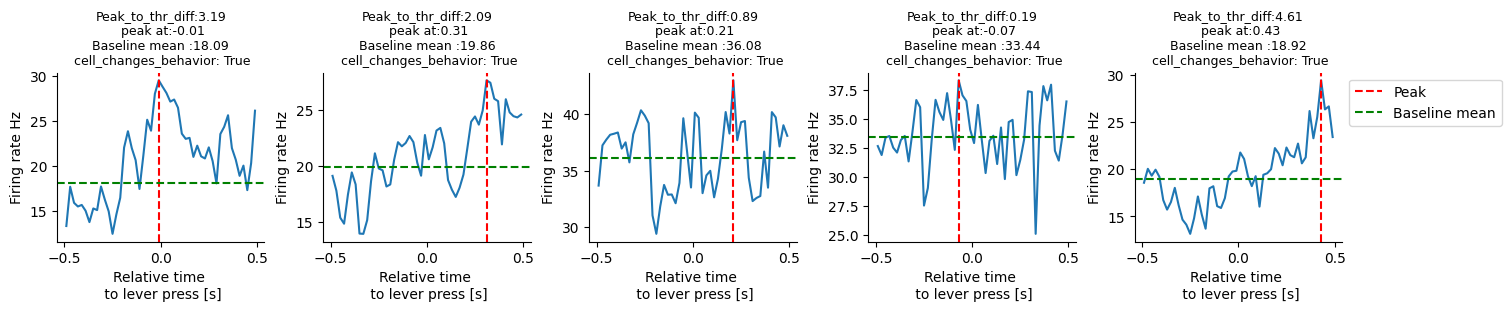

In [131]:
# Plot settings
col = 5
row = 1
sizePerRow, sizePerCol = 3, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

# Define the positions and text positions for each subplot
cinds = [1, 0, 3, 2, 4]  # Example cind values to loop through (0 to 4)
text_positions = [[-0.4, 32], [-0.4, 30], [-0.4, 45], [-0.4, 40], [-0.4, 31]]  # Example positions for text
timestd=2

for i, cind in enumerate(cinds):
    # Create subplot
    ax = fig.add_subplot(gs[i])
    
    # Get data for the current cind
    arr,peak_index, baseline_mean, peak_to_threshold_diff, threshold, peak_value, behavior_change = get_peak_to_baseline(stacked_ifr_fs, cind, time_scaled, timestd=timestd)
    
    # Plot the data
    #plot_peak_tobaseline_diff(ax, cind, arr, peak_index, baseline_mean, peak_to_threshold_diff,behavior_change, text_pos=text_positions[i], legend=(i == 4))  # Legend only for the third plot
    
    plot_peak_tobaseline_diff(ax, cind, arr, peak_index, baseline_mean, peak_to_threshold_diff,behavior_change, legend=(i == 4))


In [122]:
def get_peak_to_baseline(stackedifr_cells, cind,trials_light_ids, time_scaled, timestd=5):
    
    neuron_fr_max = np.nanmax(stackedifr_cells, axis=(0, 2))
    
    with np.errstate(invalid='ignore'):
        stackedifr_cells_normalized = (stackedifr_cells.transpose((0, 2, 1)) / neuron_fr_max).transpose(0, 2, 1)
    
    ifr_stack= stackedifr_cells_normalized[trials_light_ids][:, cind]
    #arr = np.nanmean(stackedifr_cells[:, cind, :], axis=0).T
    arr = np.nanmean(ifr_stack, axis=0).T
    
    # Step 1: Find the index of the highest peak
    peak_index = np.argmax(arr)
    peak_value = arr[peak_index]

    # Step 2: Calculate the baseline mean and standard deviation
    # The baseline is calculated from the start up to (but not including) the peak
    baseline_mask = time_scaled < time_scaled[peak_index]
    baseline_values = arr[baseline_mask]

    baseline_mean = np.mean(baseline_values)
    baseline_std = np.std(baseline_values)

    # Step 3: Calculate the positive and negative thresholds
    positive_threshold = baseline_mean + timestd * baseline_std
    negative_threshold = baseline_mean - timestd * baseline_std

    # Step 4: Calculate the difference between the peak and both thresholds
    peak_to_positive_threshold_diff = peak_value - positive_threshold
    peak_to_negative_threshold_diff = peak_value - negative_threshold

    # Step 5: Classify whether the cell changes behavior in either direction
    if peak_to_positive_threshold_diff > 0 or peak_to_negative_threshold_diff < 0:
        behavior_change = True
    else:
        behavior_change = False
    
    return arr,peak_index, baseline_mean, peak_to_threshold_diff, threshold, peak_value, behavior_change

def plot_peak_tobaseline_diff(ax, cind, arr, peak_index, baseline_mean, peak_to_threshold_diff,behavior_change, legend= True):
    ax.plot(time_scaled, arr)
    ax.axvline(time_scaled[peak_index], color='r', linestyle='--', label=f'Peak')
    #ax.set_ylim(0,30)
    ax.set_ylabel('Firing rate Hz')
    ax.set_xlabel('Relative time \n to lever press [s]')
    ax.axhline(baseline_mean, color='g', linestyle='--', label=f'Baseline mean')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if legend:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_title( f'Peak_to_thr_diff:{peak_to_threshold_diff:.2f}\n peak at:{time_scaled[peak_index]:.2f}\n Baseline mean :{baseline_mean:.2f} \n cell_changes_behavior: {behavior_change}', fontsize=9)

In [126]:
stackedifr_cells.shape

(93, 43, 50)

In [123]:
cind= 0
arr,peak_index, baseline_mean, peak_to_threshold_diff, threshold, peak_value, behavior_change= get_peak_to_baseline(stackedifr_cells, cind,trials_light_ids, time_scaled, timestd=5)

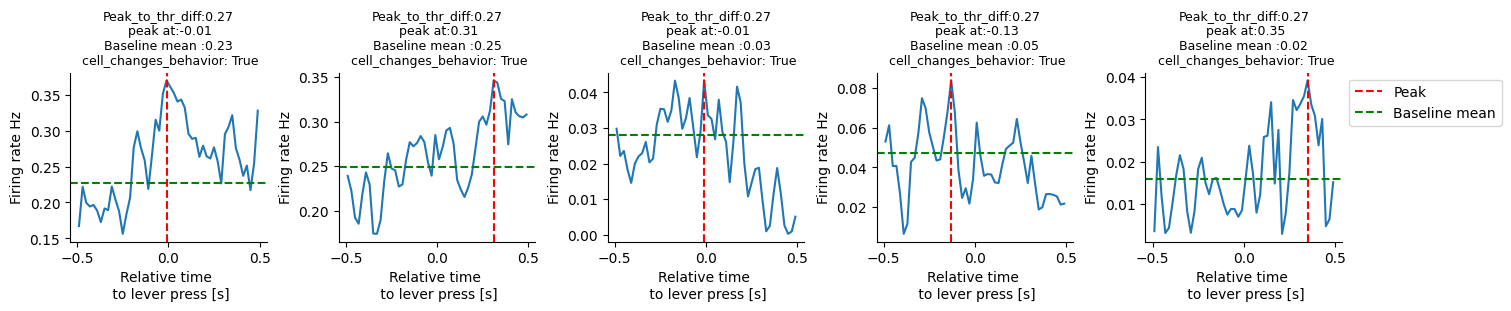

In [125]:
# Plot settings
col = 5
row = 1
sizePerRow, sizePerCol = 3, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

# Define the positions and text positions for each subplot
cinds = [1, 0, 3, 2, 4]  # Example cind values to loop through (0 to 4)
text_positions = [[-0.4, 32], [-0.4, 30], [-0.4, 45], [-0.4, 40], [-0.4, 31]]  # Example positions for text
timestd=2

for i, cind in enumerate(cinds):
    # Create subplot
    ax = fig.add_subplot(gs[i])
    
    # Get data for the current cind
    arr,peak_index, baseline_mean, peak_to_threshold_diff, threshold, peak_value, behavior_change= get_peak_to_baseline(stackedifr_cells, cind,trials_light_ids, time_scaled, timestd=timestd)
    
    # Plot the data
    #plot_peak_tobaseline_diff(ax, cind, arr, peak_index, baseline_mean, peak_to_threshold_diff,behavior_change, text_pos=text_positions[i], legend=(i == 4))  # Legend only for the third plot
    
    plot_peak_tobaseline_diff(ax, cind, arr, peak_index, baseline_mean, peak_to_threshold_diff,behavior_change, legend=(i == 4))


## run this on all the cells and save the result in a df 

In [ ]:
sSesNames = []
numgcs = []
numfs = []
gc_indxs = []
fsin_indxs = []

stacked_ifr_fsls = []
stacked_ifr_fsds = []
stacked_ifr_gcds = []
stacked_ifr_gcls = []
stackedifr_cellss_normalized = []
times = []
times_scaled = []
expvalsls = []
expvalsds = []

for sSes, stack in zip(sSessions, get_stacked_ifr_all_sessions[:]):
    sSesNames.append(sSes.name)
    stackedifr_cells, trials_light_ids, trials_dark_ids, time_scaled = stack[0], stack[1], stack[2], stack[3]
    
    session_cells = cells[(cells.session == sSes.name)]
    gc_indx = session_cells.gridCell_FIRST.values
    fsin_indx = ((session_cells.interneuron) & (session_cells.mrate_RF1 > 10)).values
    
    numgcs.append(sum(gc_indx))
    numfs.append(sum(fsin_indx))
    gc_indxs.append(gc_indx)
    fsin_indxs.append(fsin_indx)
    #times.append(time)
    times_scaled.append(time_scaled)
    
    stacked_ifr_fsls.append(stackedifr_cells[trials_light_ids][:, fsin_indx])
    stacked_ifr_gcls.append(stackedifr_cells[trials_light_ids][:, gc_indx])
    
    stacked_ifr_fsds.append(stackedifr_cells[trials_dark_ids][:, fsin_indx])
    stacked_ifr_gcds.append(stackedifr_cells[trials_dark_ids][:, gc_indx])
    
    cell_filters = [fsin_indx, gc_indx]
    light_conditions = [trials_light_ids, trials_dark_ids]
    neuron_fr_max = np.nanmax(stackedifr_cells, axis=(0, 2))
    
    with np.errstate(invalid='ignore'):
        stackedifr_cells_normalized = (stackedifr_cells.transpose((0, 2, 1)) / neuron_fr_max).transpose(0, 2, 1)
    
    expvalsl = []
    expvalsd = []
    light_conditions = [trials_light_ids, trials_dark_ids]
    light_conditions_str = ['light', 'dark']
    
    for light_condition, light_condition_str in zip(light_conditions, light_conditions_str):
        for cell_filter, cell_filter_str in zip(cell_filters, ['FSIN', 'GC']):
            ifrstack = stackedifr_cells_normalized[light_condition][:, cell_filter]
            if ifrstack.shape[1] != 0:
                s0 = np.nanmean(ifrstack, axis=(0, 1))
                t_mean = expected_value(time_scaled, s0)
                if light_condition_str == 'light':
                    expvalsl.append(t_mean)
                else:
                    expvalsd.append(t_mean)
    
    # Ensure expvalsl and expvalsd have at least two elements
    if len(expvalsl) < 2:
        expvalsl.extend([np.nan] * (2 - len(expvalsl)))
    if len(expvalsd) < 2:
        expvalsd.extend([np.nan] * (2 - len(expvalsd)))

    # Append to expvalsls and expvalsds lists only once per session
    expvalsds.append(expvalsd)
    expvalsls.append(expvalsl)